In [1]:
%pip install langchain-text-splitters
%pip install PyMuPDF
%pip install -U langchain-community
%pip install -U langchain-openai
%pip install faiss-cpu
%pip install -U langchain-huggingface
!pip install PyPDF2
!pip install -q pypdf langchain transformers sentence-transformers faiss-cpu
%pip install pypdf
%pip install tavily-python transformers torch requests

In [2]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

# 1. Load the PDF document
loader = PyPDFLoader("/content/doc.pdf")  # Make sure the file is in your working directory
pages = loader.load()

# Combine all pages into a single text
full_text = "\n".join([page.page_content for page in pages])

# 2. Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,       # Number of characters per chunk
    chunk_overlap=100,     # Overlap between chunks for context
    length_function=len,   # Function to measure length
    is_separator_regex=False,
)

# 3. Split the document into chunks
# chunks = text_splitter.create_documents([full_text])

chunks = text_splitter.create_documents(
    [full_text],
    metadatas=[{"source": "clinical_summarization.pdf"}]*len(pages)
)

# 4. Initialize HuggingFace embeddings
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",  # Good general-purpose model
    model_kwargs={"device": "cpu"},  # Use "cuda" if you have GPU
    encode_kwargs={"normalize_embeddings": True}  # Normalize to unit vectors
)

# 5. Create FAISS vector store
vector_store = FAISS.from_documents(
    documents=chunks,
    embedding=embedding_model
)

# Save the index locally
vector_store.save_local("clinical_summarization_faiss_index")

# Example usage: similarity search
query = "What are the challenges of AI in clinical summarization?"
docs = vector_store.similarity_search(query, k=3)  # Retrieve top 3 most similar chunks

print(f"Found {len(chunks)} chunks in the document")
print("\nTop results for your query:")
for i, doc in enumerate(docs):
    print(f"\nResult {i+1}:")
    print(doc.page_content[:500] + "...")  # Print first 500 chars of each result

/tmp/ipython-input-2-516437911.py:30: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Found 56 chunks in the document

Top results for your query:

Result 1:
adaptation of clinical workflows are essential factors that must be addressed to achieve seamless integration and
utilization.
10 Moving Forward
AI in clinical summarization offers transformative potential for healthcare, promising to enhance the efficiency and
accuracy of medical documentation and decision-making. However, realizing this potential requires overcoming
substantial challenges in data management, system integration, and maintaining the ethical standards of patient care....

Result 2:
with patient chart review.
8 Methodologies Behind Innovating AI into Clinical Summarization
Beyond the typical usages of AI in clinical summarization, there have also been efforts to improve AI performance
in clinical settings. The SPeC framework represents a breakthrough in addressing the variability of AI outputs in
clinical summarization. By employing soft prompts, this method enhances the stability and consistency of 

Use .similarity_search() to see what documents match a query.

In [3]:
# 1. Load your pre-built FAISS index (if you saved it previously)
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
vector_store = FAISS.load_local("clinical_summarization_faiss_index", embedding_model, allow_dangerous_deserialization=True)

# 2. Define your query
query = "What are the challenges of storing patient information?"

# # 3. Perform similarity search
# results = vector_store.similarity_search(
#     query=query,
#     k=3  # Retrieve top 3 most relevant chunks
# )

  # Filter by metadata
# results = vector_store.similarity_search(
#       query,
#       k=2,
#       filter={"page": 5}  # Only return chunks from page 5
# )

    # Maximum marginal relevance search (balances similarity and diversity):
results = vector_store.max_marginal_relevance_search(
    query,
    k=3,
    lambda_mult=0.5  # 0=exact similarity, 1=max diversity
)

# 4. Display results
print(f"Top {len(results)} results for: '{query}'\n")
for i, doc in enumerate(results):
    print(f"=== Result {i+1} ===")
    print(doc.page_content.strip())
    print("\n" + "-"*80 + "\n")

# Search with score thresholds:
    docs_and_scores = vector_store.similarity_search_with_score(query, k=3)
for doc, score in docs_and_scores:
    print(f"Score: {score:.3f}")
    print(doc.page_content[:300] + "...\n")


Top 3 results for: 'What are the challenges of storing patient information?'

=== Result 1 ===
limited to reductions of administrative burden and improved patient-centered care.
1 Introduction
Patient information is critical in the delivery of effective care – thousands of practices, tools, and techniques have been
developed in patient interview, health record storage, and physical examination purely for the sake of effective usage of
key patient information. Clinicians must have an effective understanding of a patient – including but not limited to

--------------------------------------------------------------------------------

=== Result 2 ===
75% of physicians facing burnout cite EHR workflow as the main contributor,[15] especially in primary care, where
burnout rates are the highest at 50%. This high correlation between burnout and EHR workflow can be attributed to the
fact that physicians spend 49.2% of their time per day with EHRs while only 27% is dedicated towards face-to-fac

Visualize embeddings using PCA or t-SNE.

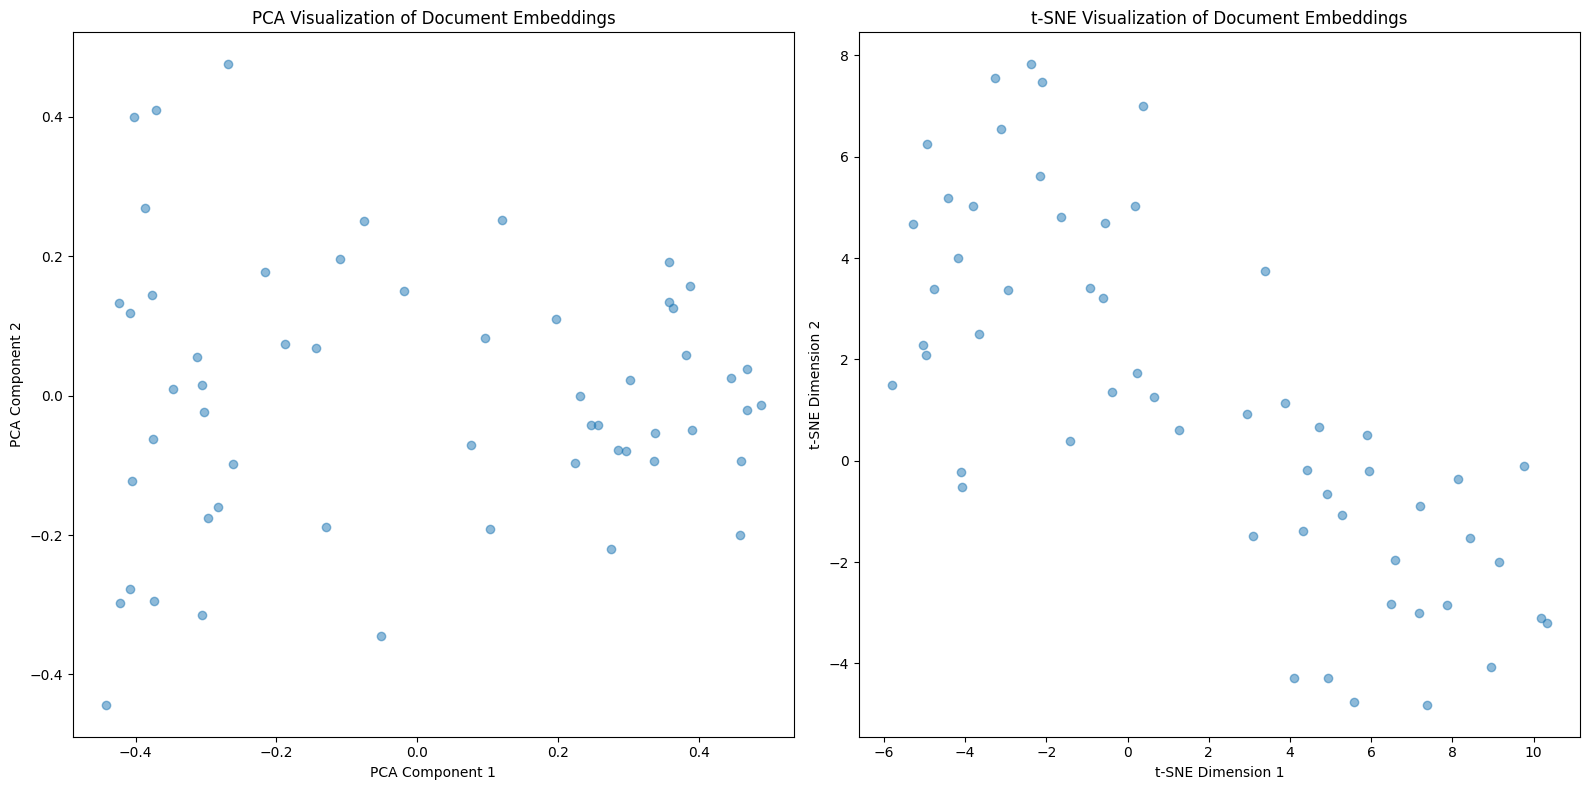

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

# 1. Load your FAISS index
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
vector_store = FAISS.load_local("clinical_summarization_faiss_index", embedding_model, allow_dangerous_deserialization=True)

# 2. Get all embeddings from the index
embeddings = vector_store.index.reconstruct_n(0, vector_store.index.ntotal)
embeddings = np.array(embeddings)  # Convert to numpy array

# 3. Reduce dimensions with PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(embeddings)

# 4. Reduce dimensions with t-SNE (slower but better for visualization)
tsne = TSNE(n_components=2, perplexity=15, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# 5. Create visualization
plt.figure(figsize=(16, 8))

# PCA Plot
plt.subplot(1, 2, 1)
plt.scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.5)
plt.title('PCA Visualization of Document Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# t-SNE Plot
plt.subplot(1, 2, 2)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of Document Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.tight_layout()
plt.show()




In [5]:
# Left Plot: PCA Visualization
# Title: "PCA Visualization of Document Embeddings"

# Axes: PCA Component 1 (x-axis) vs PCA Component 2 (y-axis)


# Interpretation:

# PCA (Principal Component Analysis) is a linear technique that projects high-dimensional data into 2D by maximizing variance along new orthogonal axes.

# In this plot, the data points appear somewhat uniformly scattered without obvious clustering or structure.

# This may suggest that PCA is not capturing non-linear structures or clusters in your document embeddings effectively.


# Right Plot: t-SNE Visualization
# Title: "t-SNE Visualization of Document Embeddings"

# Axes: t-SNE Dimension 1 (x-axis) vs t-SNE Dimension 2 (y-axis)

# Interpretation:

# t-SNE (t-distributed Stochastic Neighbor Embedding) is a non-linear dimensionality reduction technique particularly good for preserving local structures (i.e., clusters or neighborhoods).

# The t-SNE plot shows a more structured distribution—points are more spread out and suggest some grouping.

# This often indicates that t-SNE is better at revealing the underlying groupings or topics in your document embeddings compared to PCA.

# | Feature             | PCA                                     | t-SNE                                            |
# | ------------------- | --------------------------------------- | ------------------------------------------------ |
# | Type                | Linear                                  | Non-linear                                       |
# | Captures clusters   | Poorly (in this case)                   | Better—local clusters are visible                |
# | Computational speed | Fast                                    | Slower and more computationally intensive        |
# | Use case            | Good for global structure, quick checks | Good for visualizing local structure or clusters |


# Conclusion
# PCA gives a general, but rough idea of how your document embeddings vary.

# t-SNE provides a more interpretable view if you're looking for natural groupings (e.g., topics or semantic similarity).

In [6]:
# 1. Load your pre-built FAISS index (if you saved it previously)
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
vector_store = FAISS.load_local("clinical_summarization_faiss_index", embedding_model, allow_dangerous_deserialization=True)

# 2. Define your query
query = "What are the challenges of storing patient information?"

# # 3. Perform similarity search
# results = vector_store.similarity_search(
#     query=query,
#     k=3  # Retrieve top 3 most relevant chunks
# )

  # Filter by metadata
# results = vector_store.similarity_search(
#       query,
#       k=2,
#       filter={"page": 5}  # Only return chunks from page 5
# )

    # Maximum marginal relevance search (balances similarity and diversity):
results = vector_store.max_marginal_relevance_search(
    query,
    k=3,
    lambda_mult=0.5  # 0=exact similarity, 1=max diversity
)

# 4. Display results
print(f"Top {len(results)} results for: '{query}'\n")
for i, doc in enumerate(results):
    print(f"=== Result {i+1} ===")
    print(doc.page_content.strip())
    print("\n" + "-"*80 + "\n")

# Search with score thresholds:
docs_and_scores = vector_store.similarity_search_with_score(query, k=3)
for doc, score in docs_and_scores:
    print(f"Score: {score:.3f}")
    print(doc.page_content[:300] + "...\n")

Top 3 results for: 'What are the challenges of storing patient information?'

=== Result 1 ===
limited to reductions of administrative burden and improved patient-centered care.
1 Introduction
Patient information is critical in the delivery of effective care – thousands of practices, tools, and techniques have been
developed in patient interview, health record storage, and physical examination purely for the sake of effective usage of
key patient information. Clinicians must have an effective understanding of a patient – including but not limited to

--------------------------------------------------------------------------------

=== Result 2 ===
75% of physicians facing burnout cite EHR workflow as the main contributor,[15] especially in primary care, where
burnout rates are the highest at 50%. This high correlation between burnout and EHR workflow can be attributed to the
fact that physicians spend 49.2% of their time per day with EHRs while only 27% is dedicated towards face-to-fac

Add new documents to doc.pdf


In [7]:
from PyPDF2 import PdfMerger, PdfReader
import os

def merge_pdfs(existing_pdf_path, new_pdf_paths, output_path="updated_doc.pdf"):
    """
    Merges an existing PDF with one or more new PDF files.

    Args:
        existing_pdf_path (str): The path to the original PDF file.
        new_pdf_paths (list): A list of paths to the new PDF files to merge.
        output_path (str): The path to save the merged PDF. Defaults to "updated_doc.pdf".

    Returns:
        str: The path to the newly created merged PDF file.
    """
    merger = PdfMerger()

    # Add the existing PDF
    if os.path.exists(existing_pdf_path):
        merger.append(PdfReader(existing_pdf_path))
    else:
        print(f"Warning: Existing PDF not found at {existing_pdf_path}. Starting with new documents.")

    # Add the new PDFs
    for new_pdf_path in new_pdf_paths:
        if os.path.exists(new_pdf_path):
            merger.append(PdfReader(new_pdf_path))
        else:
            print(f"Warning: New PDF not found at {new_pdf_path}. Skipping.")


    # Write the merged PDF to the output file
    with open(output_path, "wb") as output_file:
        merger.write(output_file)

    merger.close()
    return output_path

new_doc_paths = ["/content/TheroleofAIinhealthcare.pdf"]  # Your new files
updated_pdf = merge_pdfs("doc.pdf", new_doc_paths)
print(f"Merged PDF saved to: {updated_pdf}")

Merged PDF saved to: updated_doc.pdf


Step 2: Rebuild FAISS Index with Updated Content

In [8]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
import os

def rebuild_index(pdf_path, index_path="clinical_faiss_index"):
    # 1. Load and split documents with medical-aware chunking
    loader = PyPDFLoader(pdf_path)
    pages = loader.load_and_split()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1200,  # Optimal for clinical notes
        chunk_overlap=300,  # Maintains context
        separators=["\n\n## ", "\n\n• ", "\n", "\. ", " "],
        keep_separator=True
    )
    chunks = text_splitter.split_documents(pages)

    # 2. Initialize embeddings with correct parameters
    embedding_model = HuggingFaceEmbeddings(
        model_name="emilyalsentzer/Bio_ClinicalBERT",
        model_kwargs={"device": "cpu"},
        encode_kwargs={  # Removed show_progress_bar from here
            "normalize_embeddings": True,
            "batch_size": 32  # Better for clinical docs
        }
    )

    # 3. Create and save index
    vector_store = FAISS.from_documents(
        documents=chunks,
        embedding=embedding_model,
        normalize_L2=True  # Improves clinical similarity search
    )
    vector_store.save_local(index_path)
    return vector_store

# Usage (after merging PDFs):
vector_store = rebuild_index("updated_doc.pdf")

test retrieval with new queries.

In [9]:
def test_clinical_retrieval(vector_store):
    test_cases = [
        ("What is the interaction of humans with AI", 3),
        ("what is The effect of Ai on healthcare delivery", 2),
        ("What is the adverse effect of AI on healthcare delivery", 3)
    ]

    for query, k in test_cases:
        print(f"\n⚕️ Clinical Query: '{query}'\n{'='*50}")
        #docs = vector_store.similarity_search(query, k=k)


# Use medical-domain specific similarity search
        docs = vector_store.max_marginal_relevance_search(
          query,
          k=3,
          lambda_mult=0.3  # Balances similarity and diversity
          )



        for i, doc in enumerate(docs, 1):
            # Safely handle missing score metadata
            score = doc.metadata.get('score')
            score_display = f"{score:.2f}" if isinstance(score, (float, int)) else "N/A"

            print(f"\n📄 Match {i} (Relevance: {score_display})")
            print(f"Source: {doc.metadata.get('source', 'Unknown')}")

            # Improved clinical content display
            content = doc.page_content.replace('\n', ' ').strip()
            print(f"Clinical Content:\n{content[:250]}{'...' if len(content) > 250 else ''}")

# Execute tests
test_clinical_retrieval(vector_store)


⚕️ Clinical Query: 'What is the interaction of humans with AI'

📄 Match 1 (Relevance: N/A)
Source: updated_doc.pdf
Clinical Content:
debate is further complicated with the advent of generative AI and its impact on workflows across the industry. However, it is no surprise that AI that automates clinical workflow is an exciting frontier. It is an undeniable truth that generative AI ...

📄 Match 2 (Relevance: N/A)
Source: updated_doc.pdf
Clinical Content:
AI algorithms can predict the risk of genetic disorders, enabling preventative measures or early  treatments tailored to the individual's genetic makeup. Similarly, in biometric data analysis, AI  applications process data from wearable devices to mo...

📄 Match 3 (Relevance: N/A)
Source: updated_doc.pdf
Clinical Content:
collection from charts. As these case studies show, many of these ADEs involve insufficient knowledge on the side of a clinician due to incomplete record review and internal inconsistencies found in the unstructured da

In [ ]:
# Create a New AI Agent with Tavily tools for trend analysis

In [11]:
import requests
from tavily import TavilyClient
from transformers import pipeline

# Initialize Tavily (replace with your API key)
TAVILY_API_KEY = "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"
tavily = TavilyClient(api_key=TAVILY_API_KEY)

# Load local summarization model from Hugging Face
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def fetch_ai_news():
    print("[🔎] Fetching AI news from the web...")
    results = tavily.search(
        query="latest AI news July 2025",
        search_depth="advanced",
        include_answer=True,
        include_raw_content=True,
        max_results=5
    )
    return results.get("results", [])

def summarize_articles(articles):
    summaries = []
    for article in articles:
        content = article.get("content", "")[:1500]  # truncate for summarizer
        if not content:
            continue
        summary = summarizer(content, max_length=150, min_length=40, do_sample=False)[0]["summary_text"]
        summaries.append({
            "title": article.get("title"),
            "url": article.get("url"),
            "summary": summary
        })
    return summaries

def display_summary(summaries):
    print("\n🧠 AI News Summary:")
    for i, item in enumerate(summaries, 1):
        print(f"\n🔹 {i}. {item['title']}")
        print(f"🔗 {item['url']}")
        print(f"📝 {item['summary']}")

def run_trend_analyst():
    articles = fetch_ai_news()
    if not articles:
        print("No articles found.")
        return

    summaries = summarize_articles(articles)
    display_summary(summaries)

if __name__ == "__main__":
    run_trend_analyst()


Device set to use cpu


[🔎] Fetching AI news from the web...


Your max_length is set to 150, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)



🧠 AI News Summary:

🔹 1. Latest AI Breakthroughs and News: May, June, July 2025
🔗 https://www.crescendo.ai/news/latest-ai-news-and-updates
📝 X’s Grok AI has come under fire for generating antisemitic responses in user chats. The company has issued an apology and says it's updating its safety systems. Despite U.S. sanctions and limited access to cutting-edge chips, China is aggressively pursuing AI development.

🔹 2. AI News | Latest AI News, Analysis & Events
🔗 https://www.artificialintelligence-news.com/
📝 Google’s Veo 3 AI video creation tools are now widely available. China doubles chooses AI self-reliance amid intense US competition. Tech giants split on EU AI code as compliance deadline looms.

🔹 3. Top AI News from July 20th-24th, 2025: The Week That Changed ...
🔗 https://www.linkedin.com/pulse/top-ai-news-from-july-20th-24th-2025-week-changed-lozovsky-mba-rsanc
📝 This week felt like a pivotal moment in AI development. We saw government fully embracing AI as a strategic priority